In [1]:
#if on collab:
from google.colab import drive
drive.mount('/content/drive')

#replace by the parh to ipeo project in the drive
%cd '/content/drive/Othercomputers/MacBook/ipeo_project copy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/MacBook/ipeo_project copy


In [2]:
#!pip install -r requirements.txt
from tqdm import tqdm
import subprocess
from PIL import Image
import numpy as np
import rasterio as rio
import pandas as pd

from utils import *
from unet_whole_model import *
from dataset import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


##### Observe the full images
We load train & test data, rebuild the full images using the merge_raster.py file and save them.

In [3]:
file_path = "glaciers_mapping_downsampled"
data_paths = {}

#build paths for each pipeline
for pipeline in ["train", "test"]:
    for date in [0,1]:
        data_paths[f"{pipeline}_date{date}"] = f"{file_path}/{pipeline}/date{date}"
    data_paths[f"{pipeline}_gt"] = f"{file_path}/{pipeline}/gt"

In [ ]:
#reconstruct full images
for key, path in tqdm(data_paths.items()):
    output_path = f"{file_path}/{key}_merged.tif"
    # Execute the command to merge rasters using subprocess and save them
    command = ["python", "glaciers_mapping_downsampled/merge_rasters.py", "-i", path, "-o", output_path]
    subprocess.run(command)

100%|██████████| 6/6 [06:25<00:00, 64.27s/it]


Then we save the RGB images in png to be able to observe them and (maybe) draw useful conclusions

In [ ]:
for key in tqdm(data_paths.keys()):
    img_path = f"{file_path}/{key}_merged"
    img = rio.open(f"{img_path}.tif").read()
    if '_gt' in key:
        rgb_image = (img).astype(np.uint8).squeeze(0) * 255
        pil_image = Image.fromarray(rgb_image) #blck and white image
    else:
        rgb_image = (img[:3]*255).astype(np.uint8).transpose(1, 2, 0)
        pil_image = Image.fromarray(rgb_image)
    save_path = f"full_rgb_images/{key}.png"
    pil_image.save(save_path)

100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


### Loading all patches

We store the patches in pytorch datasets :
{
'x' : (position_x_of_patch,
'y' : position_y_of_patch),
'patch_path' : path to the image
'augmentation' : kind of augmentation performed to get this image, currently none
}

In [4]:
all_data = {key : load_paths_data(path) for key, path in data_paths.items()}

Loading data: 100%|██████████| 351/351 [00:00<00:00, 253303.63it/s]


In [5]:
train0_dataset = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0')
train1_dataset = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'train1')
test0_dataset = PatchesDataset(all_data['test_date0'], all_data['test_gt'], 'test0')
test1_dataset = PatchesDataset(all_data['test_date1'], all_data['test_gt'], 'test1')

### Preprocessing

The preprocessing consist in the zero mean & unit variance normalization channel-wise. Means and stdsd attributes are set to the model based on the train-set. Normalization is that way applied to each image before passing to the model fro train,valisation or testing.

Note: when we pass an image to the model that does not belong to the train model, it is still the train means and stds that used.

### First Naive Training with no augmentation

Loading groundtruths: 100%|██████████| 1768/1768 [00:45<00:00, 38.45it/s]


From initial model:


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch: 0/15 Train_loss: 0.69868, Train_F1: 0.60863, Train_Accuracy: 0.437430274542062, Val_loss: 0.69468, Val_F1: 0.66092, Val_Accuracy: 0.49357


100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch: 1/15 Train_loss: 0.26154, Train_F1: 0.90108, Train_Accuracy: 0.914263920076514, Val_loss: 0.20259, Val_F1: 0.93450, Val_Accuracy: 0.93692


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch: 2/15 Train_loss: 0.17057, Train_F1: 0.93707, Train_Accuracy: 0.945190673340818, Val_loss: 0.24829, Val_F1: 0.89590, Val_Accuracy: 0.88651


100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch: 3/15 Train_loss: 0.14258, Train_F1: 0.94522, Train_Accuracy: 0.952693165102087, Val_loss: 0.15135, Val_F1: 0.94688, Val_Accuracy: 0.94789


100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch: 4/15 Train_loss: 0.12823, Train_F1: 0.94824, Train_Accuracy: 0.955377493710496, Val_loss: 0.14474, Val_F1: 0.95632, Val_Accuracy: 0.95649


100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch: 5/15 Train_loss: 0.11883, Train_F1: 0.94953, Train_Accuracy: 0.956409730993742, Val_loss: 0.14941, Val_F1: 0.94017, Val_Accuracy: 0.94369


100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch: 6/15 Train_loss: 0.11582, Train_F1: 0.94952, Train_Accuracy: 0.956445548031541, Val_loss: 0.16486, Val_F1: 0.93601, Val_Accuracy: 0.93979


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch: 7/15 Train_loss: 0.11658, Train_F1: 0.94961, Train_Accuracy: 0.956561933099946, Val_loss: 0.11186, Val_F1: 0.95245, Val_Accuracy: 0.95242


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch: 8/15 Train_loss: 0.11091, Train_F1: 0.95055, Train_Accuracy: 0.957285908326576, Val_loss: 0.09487, Val_F1: 0.95742, Val_Accuracy: 0.95899


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch: 9/15 Train_loss: 0.10585, Train_F1: 0.95228, Train_Accuracy: 0.958666610463968, Val_loss: 0.12463, Val_F1: 0.94558, Val_Accuracy: 0.94410


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch: 10/15 Train_loss: 0.09512, Train_F1: 0.95791, Train_Accuracy: 0.963488265981059, Val_loss: 0.10563, Val_F1: 0.96231, Val_Accuracy: 0.96334


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch: 11/15 Train_loss: 0.09637, Train_F1: 0.95665, Train_Accuracy: 0.962505693365872, Val_loss: 0.08933, Val_F1: 0.96503, Val_Accuracy: 0.96566


100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch: 12/15 Train_loss: 0.09237, Train_F1: 0.95934, Train_Accuracy: 0.964740400384128, Val_loss: 0.08545, Val_F1: 0.96261, Val_Accuracy: 0.96388


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch: 13/15 Train_loss: 0.08725, Train_F1: 0.96082, Train_Accuracy: 0.965969834419702, Val_loss: 0.10838, Val_F1: 0.96030, Val_Accuracy: 0.96078


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch: 14/15 Train_loss: 0.09685, Train_F1: 0.95617, Train_Accuracy: 0.961861392774347, Val_loss: 0.14205, Val_F1: 0.92648, Val_Accuracy: 0.92317


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch: 15/15 Train_loss: 0.09774, Train_F1: 0.95457, Train_Accuracy: 0.960626720192428, Val_loss: 0.09301, Val_F1: 0.95955, Val_Accuracy: 0.96077


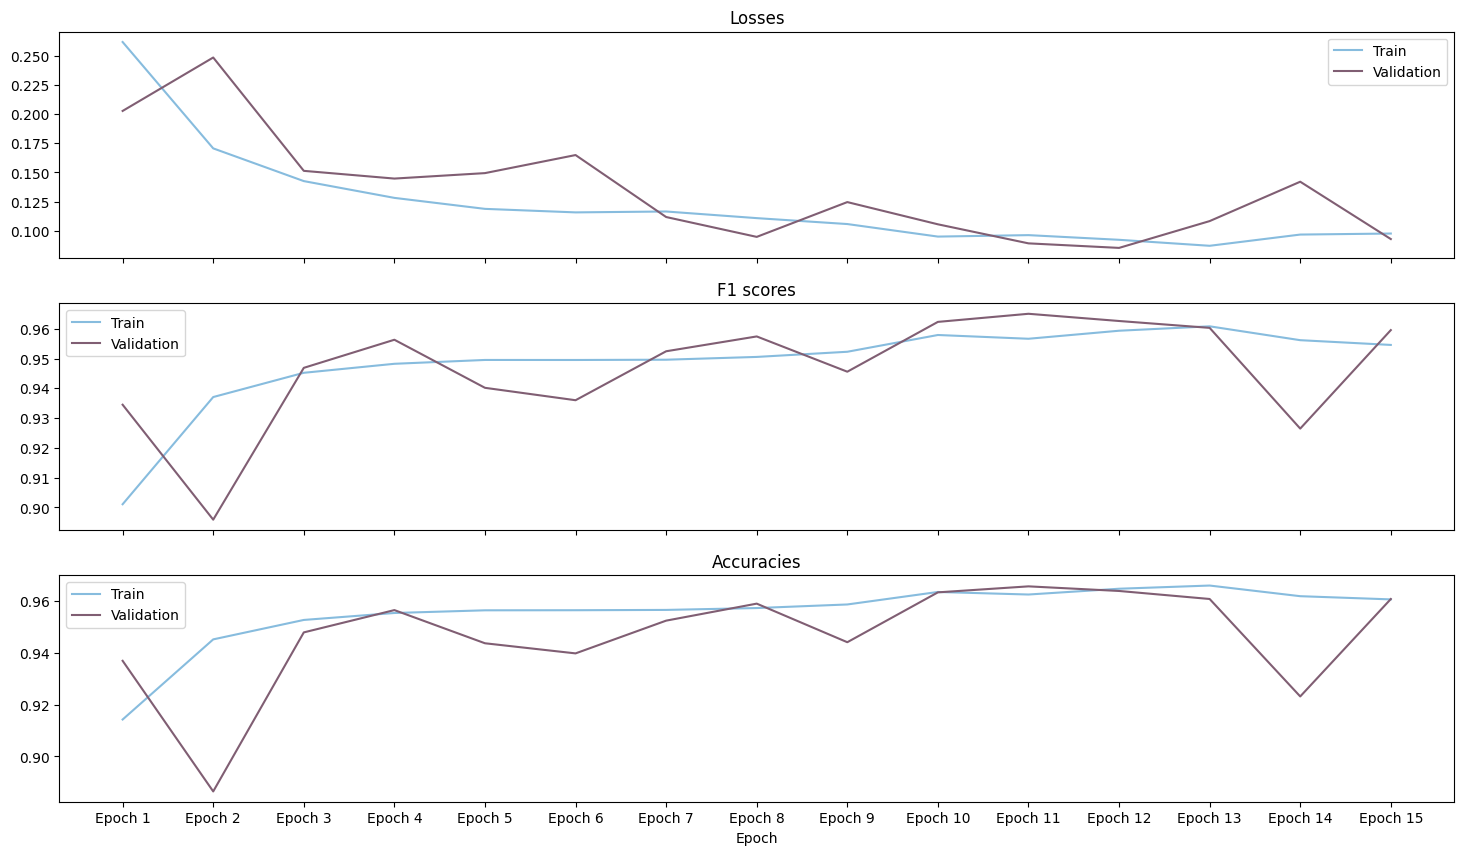

In [26]:
modelname1 = "no_augmentation_model"
lr = 8e-4
n_epochs = 15
no_augmentation_model = Model(modelname1, lr = lr)
no_augmentation_model.train(train0_dataset, num_epochs= n_epochs)
no_augmentation_model.plot_history()

In [28]:
test_records = pd.DataFrame({"model" : [],
                            "trained_on" : [],
                             "best_epoch" : [],
                             "train1" : [],
                             "train0" : [],
                             "train0_augmented" : [],
                             "train1_augmented" : [],
                             "train0&1_augmented" : [],
                             "test0" : [],
                             "test1" : []
                             })

In [31]:
train0_dataset.deload()

test_records = fill_test_record(test_records,
                 modelname1,
                 no_augmentation_model,
                 'train0',
                  [train1_dataset, test0_dataset, test1_dataset])


display(test_records)


100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,11.0,0.837378,0.965033,None,None,None,0.940868,0.791576


### Data Augmentation

In [32]:
train0_dataset_augmented = PatchesDataset(all_data['train_date0'], all_data['train_gt'], 'train0_augmented')
train0_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 1768/1768 [00:09<00:00, 195.06it/s]


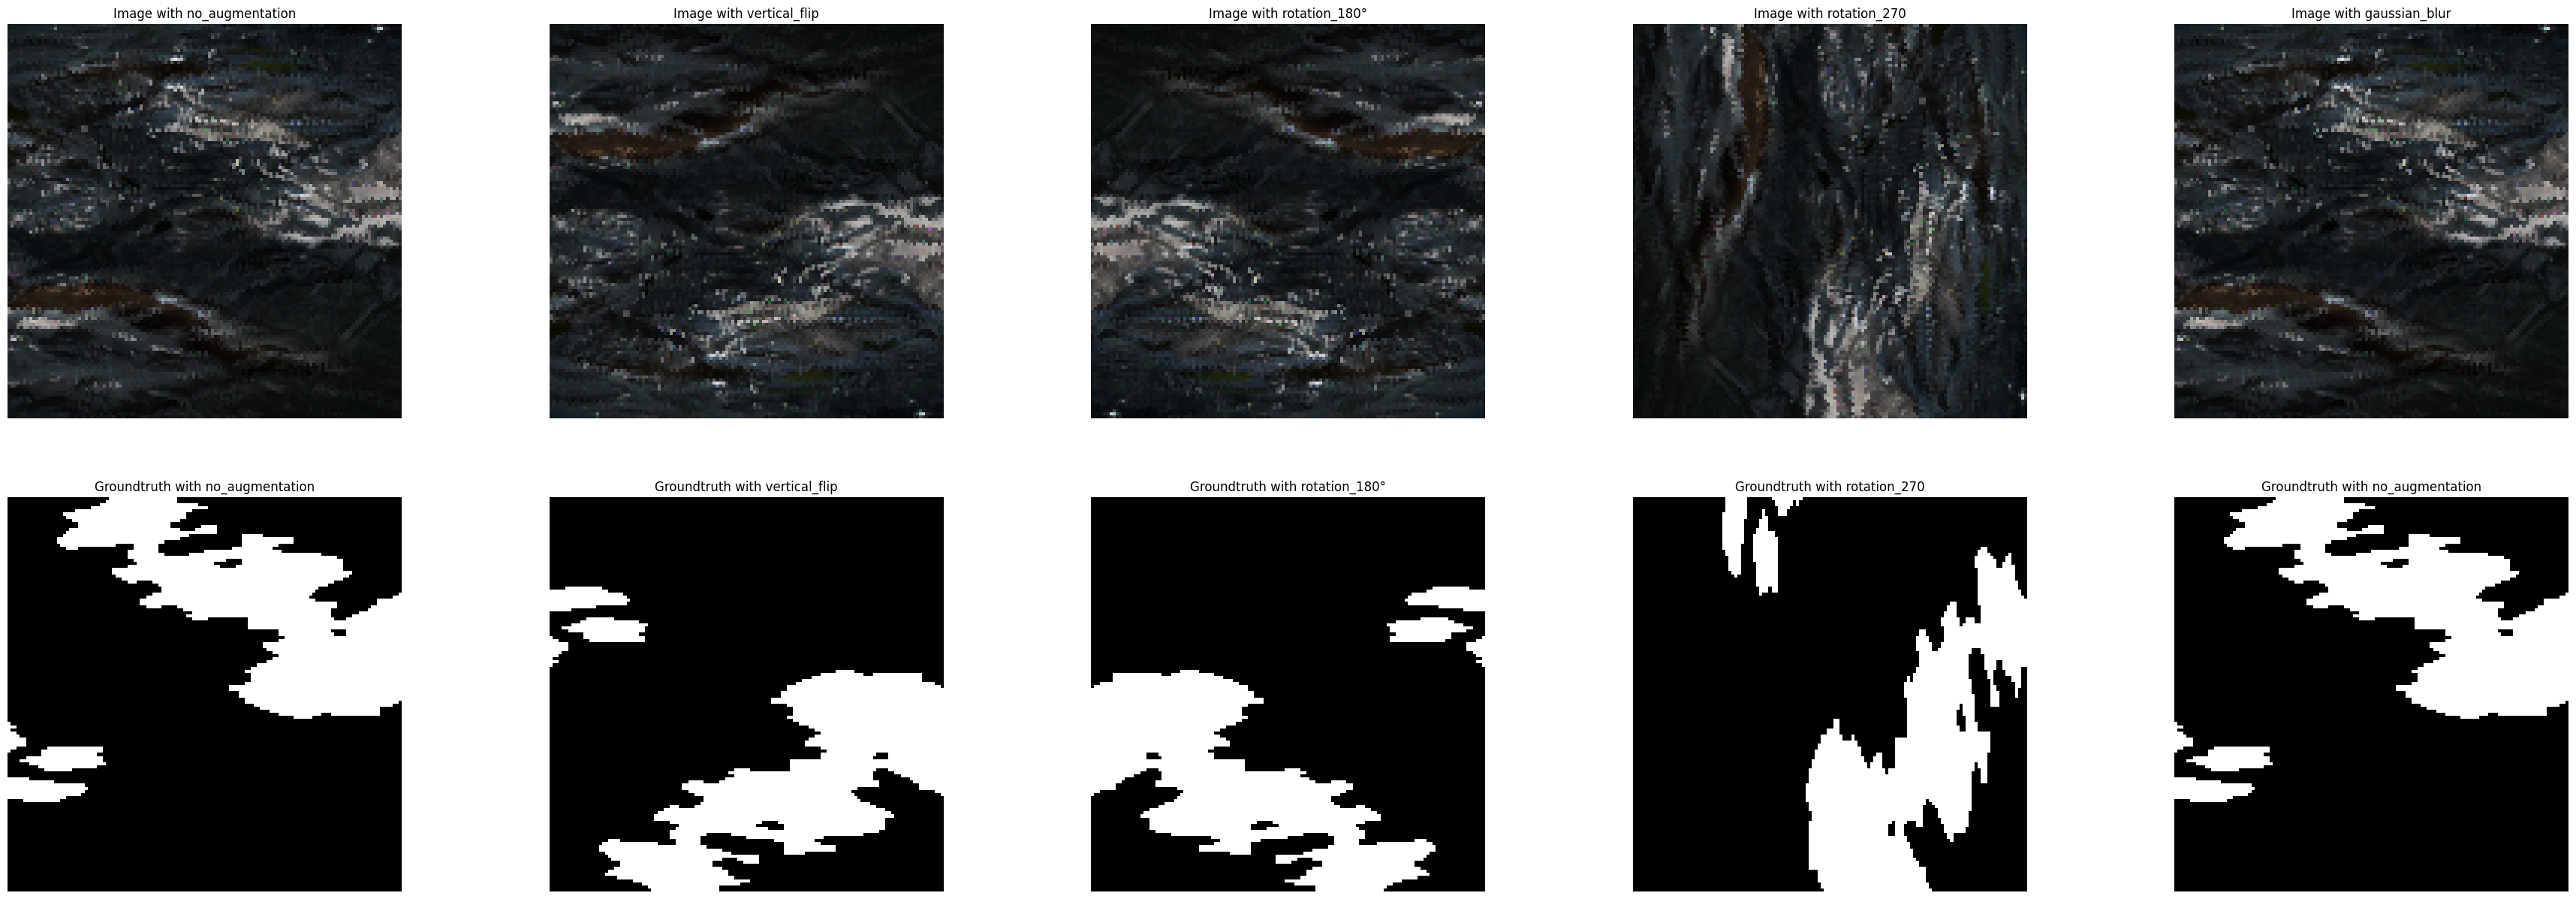

In [33]:
pos_x_ex = 3
pos_y_ex = 9

train0_dataset_augmented.plot_at_pos(pos_x_ex, pos_y_ex)

### Training with augmented data at one date

From initial model:


100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


Epoch: 0/15 Train_loss: 0.69066, Train_F1: 0.00185, Train_Accuracy: 0.555585116716624, Val_loss: 0.69071, Val_F1: 0.00196, Val_Accuracy: 0.55223


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch: 1/15 Train_loss: 0.18785, Train_F1: 0.92881, Train_Accuracy: 0.937441474498156, Val_loss: 0.14729, Val_F1: 0.94211, Val_Accuracy: 0.94914


100%|██████████| 19/19 [00:05<00:00,  3.78it/s]


Epoch: 2/15 Train_loss: 0.11552, Train_F1: 0.95158, Train_Accuracy: 0.957405540580281, Val_loss: 0.09017, Val_F1: 0.96189, Val_Accuracy: 0.96590


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 3/15 Train_loss: 0.10386, Train_F1: 0.95461, Train_Accuracy: 0.960072156716832, Val_loss: 0.09391, Val_F1: 0.96268, Val_Accuracy: 0.96655


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch: 4/15 Train_loss: 0.09625, Train_F1: 0.95675, Train_Accuracy: 0.961943447122629, Val_loss: 0.11587, Val_F1: 0.93963, Val_Accuracy: 0.94506


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 5/15 Train_loss: 0.08679, Train_F1: 0.96072, Train_Accuracy: 0.965339334524872, Val_loss: 0.08233, Val_F1: 0.96357, Val_Accuracy: 0.96748


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 6/15 Train_loss: 0.08767, Train_F1: 0.95989, Train_Accuracy: 0.964623080962968, Val_loss: 0.07829, Val_F1: 0.96461, Val_Accuracy: 0.96877


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch: 7/15 Train_loss: 0.08754, Train_F1: 0.95938, Train_Accuracy: 0.964185245572031, Val_loss: 0.10462, Val_F1: 0.95373, Val_Accuracy: 0.95980


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 8/15 Train_loss: 0.08919, Train_F1: 0.95902, Train_Accuracy: 0.963857699561941, Val_loss: 0.07805, Val_F1: 0.96431, Val_Accuracy: 0.96849


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch: 9/15 Train_loss: 0.08420, Train_F1: 0.96098, Train_Accuracy: 0.965588169467465, Val_loss: 0.07717, Val_F1: 0.96505, Val_Accuracy: 0.96856


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch: 10/15 Train_loss: 0.08337, Train_F1: 0.96157, Train_Accuracy: 0.966060562257918, Val_loss: 0.09483, Val_F1: 0.96075, Val_Accuracy: 0.96535


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch: 11/15 Train_loss: 0.08325, Train_F1: 0.96171, Train_Accuracy: 0.966220349606775, Val_loss: 0.09353, Val_F1: 0.95679, Val_Accuracy: 0.96205


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 12/15 Train_loss: 0.07882, Train_F1: 0.96325, Train_Accuracy: 0.967517750659227, Val_loss: 0.07390, Val_F1: 0.96655, Val_Accuracy: 0.97013


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


Epoch: 13/15 Train_loss: 0.07699, Train_F1: 0.96381, Train_Accuracy: 0.968040914299960, Val_loss: 0.07143, Val_F1: 0.96654, Val_Accuracy: 0.97039


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 14/15 Train_loss: 0.07651, Train_F1: 0.96430, Train_Accuracy: 0.968466400024613, Val_loss: 0.07318, Val_F1: 0.96529, Val_Accuracy: 0.96939


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch: 15/15 Train_loss: 0.07913, Train_F1: 0.96288, Train_Accuracy: 0.967226089096126, Val_loss: 0.09430, Val_F1: 0.96070, Val_Accuracy: 0.96561


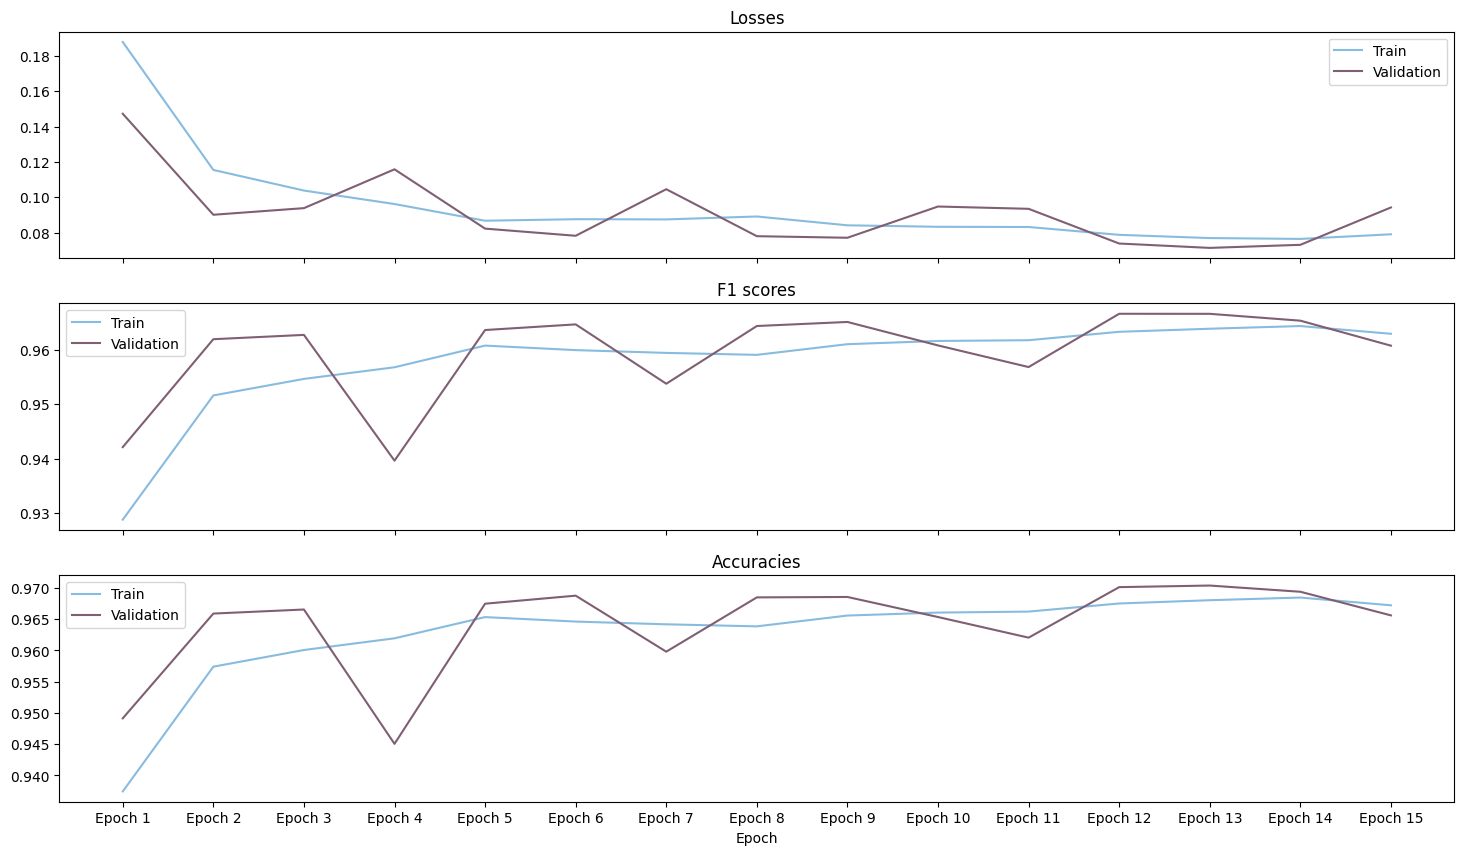

In [34]:
modelname2 = 'augmented_model0'
lr = 8e-4
n_epochs = 15
augmented_model0 = Model(modelname2, lr = lr)
augmented_model0.train(train0_dataset_augmented,num_epochs= n_epochs)
augmented_model0.plot_history()

In [37]:
train0_dataset_augmented.deload()
test_records = fill_test_record(
                test_records,
                modelname2,
                augmented_model0,
                'train0_augmented',
                [train1_dataset, test0_dataset, test1_dataset])

display(test_records)

del train0_dataset_augmented



100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,11.0,0.837378,0.965033,NaN,None,None,0.940868,0.791576
0,augmented_model0,train0_augmented,12.0,0.844863,None,0.966553,None,None,0.948449,0.755850


In [6]:
train1_dataset_augmented = PatchesDataset(all_data['train_date1'], all_data['train_gt'], 'train1_augmented')
train1_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 1768/1768 [00:13<00:00, 135.07it/s]


From initial model:


100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


Epoch: 0/15 Train_loss: 0.68880, Train_F1: 0.00000, Train_Accuracy: 0.553517746629619, Val_loss: 0.68925, Val_F1: 0.00000, Val_Accuracy: 0.54782


100%|██████████| 19/19 [00:06<00:00,  2.77it/s]


Epoch: 1/15 Train_loss: 0.19852, Train_F1: 0.91396, Train_Accuracy: 0.925106420364876, Val_loss: 0.19488, Val_F1: 0.92275, Val_Accuracy: 0.93214


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


Epoch: 2/15 Train_loss: 0.16098, Train_F1: 0.92491, Train_Accuracy: 0.933780235295034, Val_loss: 0.21246, Val_F1: 0.91443, Val_Accuracy: 0.92096


100%|██████████| 19/19 [00:05<00:00,  3.31it/s]


Epoch: 3/15 Train_loss: 0.15162, Train_F1: 0.92946, Train_Accuracy: 0.937590669473106, Val_loss: 0.26677, Val_F1: 0.87996, Val_Accuracy: 0.88213


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch: 4/15 Train_loss: 0.14337, Train_F1: 0.93324, Train_Accuracy: 0.940910542145046, Val_loss: 0.15857, Val_F1: 0.93429, Val_Accuracy: 0.94055


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


Epoch: 5/15 Train_loss: 0.13558, Train_F1: 0.93623, Train_Accuracy: 0.943670535326990, Val_loss: 0.14375, Val_F1: 0.93846, Val_Accuracy: 0.94461


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


Epoch: 6/15 Train_loss: 0.13159, Train_F1: 0.93849, Train_Accuracy: 0.945506700311831, Val_loss: 0.12658, Val_F1: 0.94211, Val_Accuracy: 0.94859


100%|██████████| 19/19 [00:05<00:00,  3.31it/s]


Epoch: 7/15 Train_loss: 0.12868, Train_F1: 0.94089, Train_Accuracy: 0.947699495553266, Val_loss: 0.19207, Val_F1: 0.92985, Val_Accuracy: 0.93925


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch: 8/15 Train_loss: 0.12565, Train_F1: 0.94165, Train_Accuracy: 0.948349170267969, Val_loss: 0.12261, Val_F1: 0.94452, Val_Accuracy: 0.95098


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch: 9/15 Train_loss: 0.12243, Train_F1: 0.94328, Train_Accuracy: 0.949733979731569, Val_loss: 0.15153, Val_F1: 0.93783, Val_Accuracy: 0.94306


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch: 10/15 Train_loss: 0.12169, Train_F1: 0.94393, Train_Accuracy: 0.950354614978842, Val_loss: 0.43421, Val_F1: 0.81382, Val_Accuracy: 0.79577


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch: 11/15 Train_loss: 0.11807, Train_F1: 0.94513, Train_Accuracy: 0.951426975275030, Val_loss: 0.12565, Val_F1: 0.94383, Val_Accuracy: 0.95060


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch: 12/15 Train_loss: 0.11105, Train_F1: 0.94828, Train_Accuracy: 0.954214556852319, Val_loss: 0.13725, Val_F1: 0.93830, Val_Accuracy: 0.94621


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


Epoch: 13/15 Train_loss: 0.10997, Train_F1: 0.94838, Train_Accuracy: 0.954313031470924, Val_loss: 0.10396, Val_F1: 0.95266, Val_Accuracy: 0.95747


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


Epoch: 14/15 Train_loss: 0.10955, Train_F1: 0.94864, Train_Accuracy: 0.954533549363417, Val_loss: 0.14567, Val_F1: 0.93933, Val_Accuracy: 0.94339


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch: 15/15 Train_loss: 0.10884, Train_F1: 0.94958, Train_Accuracy: 0.955388519233032, Val_loss: 0.28052, Val_F1: 0.87975, Val_Accuracy: 0.87899


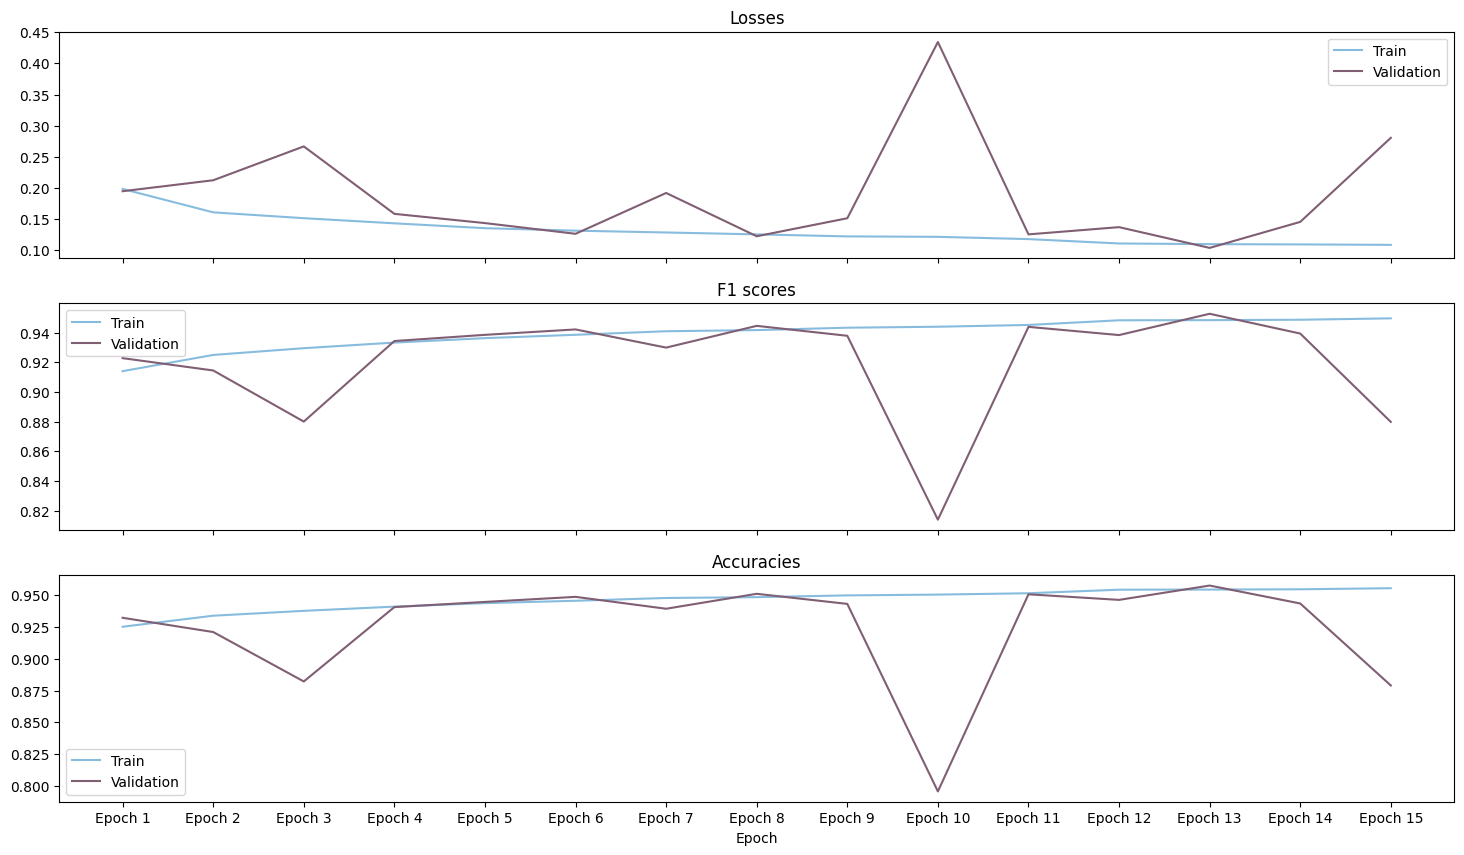

In [8]:
modelname3 = 'augmented_model1'
lr = 8e-4
n_epochs = 15
augmented_model1 = Model(modelname3, lr = lr)
augmented_model1.train(train1_dataset_augmented,num_epochs= n_epochs)
augmented_model1.plot_history()

In [10]:
train1_dataset_augmented.deload()
test_records = fill_test_record(
                test_records,
                modelname3,
                augmented_model1,
                'train1_augmented',
                [train0_dataset, test0_dataset, test1_dataset])

display(test_records)

del train1_dataset_augmented



100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1
0,no_augmentation_model,train0,11,0.837378,0.965033,NaN,NaN,NaN,0.940868,0.791576
1,augmented_model0,train0_augmented,12,0.844863,NaN,0.966553,NaN,NaN,0.948449,0.755850
0,augmented_model1,train1_augmented,13,None,0.934530,None,0.952662,None,0.861882,0.779487


### Training with augmented data at both dates

In [11]:
train0_and_1_dataset_augmented = PatchesDataset(all_data['train_date0'] + all_data['train_date1'],
                                                all_data['train_gt'] + all_data['train_gt'],
                                                "both_dates")
train0_and_1_dataset_augmented.augment()

Augmenting dataset: 100%|██████████| 3536/3536 [00:36<00:00, 96.50it/s]


From initial model:


100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


Epoch: 0/15 Train_loss: 0.69752, Train_F1: 0.61548, Train_Accuracy: 0.444539842810303, Val_loss: 0.69658, Val_F1: 0.62468, Val_Accuracy: 0.45421


100%|██████████| 38/38 [00:19<00:00,  1.99it/s]


Epoch: 1/15 Train_loss: 0.19920, Train_F1: 0.91303, Train_Accuracy: 0.923750730976187, Val_loss: 0.16331, Val_F1: 0.93140, Val_Accuracy: 0.94007


100%|██████████| 38/38 [00:17<00:00,  2.20it/s]


Epoch: 2/15 Train_loss: 0.15525, Train_F1: 0.93048, Train_Accuracy: 0.938945584470126, Val_loss: 0.14489, Val_F1: 0.94076, Val_Accuracy: 0.94753


100%|██████████| 38/38 [00:13<00:00,  2.78it/s]


Epoch: 3/15 Train_loss: 0.13622, Train_F1: 0.93765, Train_Accuracy: 0.945119920754592, Val_loss: 0.14010, Val_F1: 0.93859, Val_Accuracy: 0.94390


100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


Epoch: 4/15 Train_loss: 0.12467, Train_F1: 0.94282, Train_Accuracy: 0.949680258908332, Val_loss: 0.54405, Val_F1: 0.63937, Val_Accuracy: 0.75772


100%|██████████| 38/38 [00:17<00:00,  2.16it/s]


Epoch: 5/15 Train_loss: 0.11788, Train_F1: 0.94503, Train_Accuracy: 0.951556839226441, Val_loss: 0.15063, Val_F1: 0.92895, Val_Accuracy: 0.93274


100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


Epoch: 6/15 Train_loss: 0.11328, Train_F1: 0.94724, Train_Accuracy: 0.953490858550958, Val_loss: 0.11798, Val_F1: 0.94826, Val_Accuracy: 0.95260


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch: 7/15 Train_loss: 0.11214, Train_F1: 0.94790, Train_Accuracy: 0.954110720032326, Val_loss: 0.12102, Val_F1: 0.94725, Val_Accuracy: 0.95247


100%|██████████| 38/38 [00:15<00:00,  2.45it/s]


Epoch: 8/15 Train_loss: 0.10619, Train_F1: 0.95061, Train_Accuracy: 0.956487747971699, Val_loss: 0.10573, Val_F1: 0.95154, Val_Accuracy: 0.95644


100%|██████████| 38/38 [00:13<00:00,  2.78it/s]


Epoch: 9/15 Train_loss: 0.10731, Train_F1: 0.94997, Train_Accuracy: 0.955937564152422, Val_loss: 0.11726, Val_F1: 0.94724, Val_Accuracy: 0.95157


100%|██████████| 38/38 [00:17<00:00,  2.19it/s]


Epoch: 10/15 Train_loss: 0.10422, Train_F1: 0.95193, Train_Accuracy: 0.957645541063333, Val_loss: 0.13112, Val_F1: 0.93769, Val_Accuracy: 0.94353


100%|██████████| 38/38 [00:15<00:00,  2.38it/s]


Epoch: 11/15 Train_loss: 0.10662, Train_F1: 0.95015, Train_Accuracy: 0.956082901012271, Val_loss: 0.11615, Val_F1: 0.94894, Val_Accuracy: 0.95290


100%|██████████| 38/38 [00:13<00:00,  2.78it/s]


Epoch: 12/15 Train_loss: 0.10052, Train_F1: 0.95321, Train_Accuracy: 0.958764675544157, Val_loss: 0.09899, Val_F1: 0.95560, Val_Accuracy: 0.95952


100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


Epoch: 13/15 Train_loss: 0.09626, Train_F1: 0.95512, Train_Accuracy: 0.960429855561274, Val_loss: 1.18280, Val_F1: 0.39832, Val_Accuracy: 0.65385


100%|██████████| 38/38 [00:18<00:00,  2.04it/s]


Epoch: 14/15 Train_loss: 0.11713, Train_F1: 0.94475, Train_Accuracy: 0.951313087130193, Val_loss: 0.09684, Val_F1: 0.95647, Val_Accuracy: 0.96085


100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Epoch: 15/15 Train_loss: 0.10369, Train_F1: 0.95264, Train_Accuracy: 0.958279299224244, Val_loss: 0.57247, Val_F1: 0.83881, Val_Accuracy: 0.82984


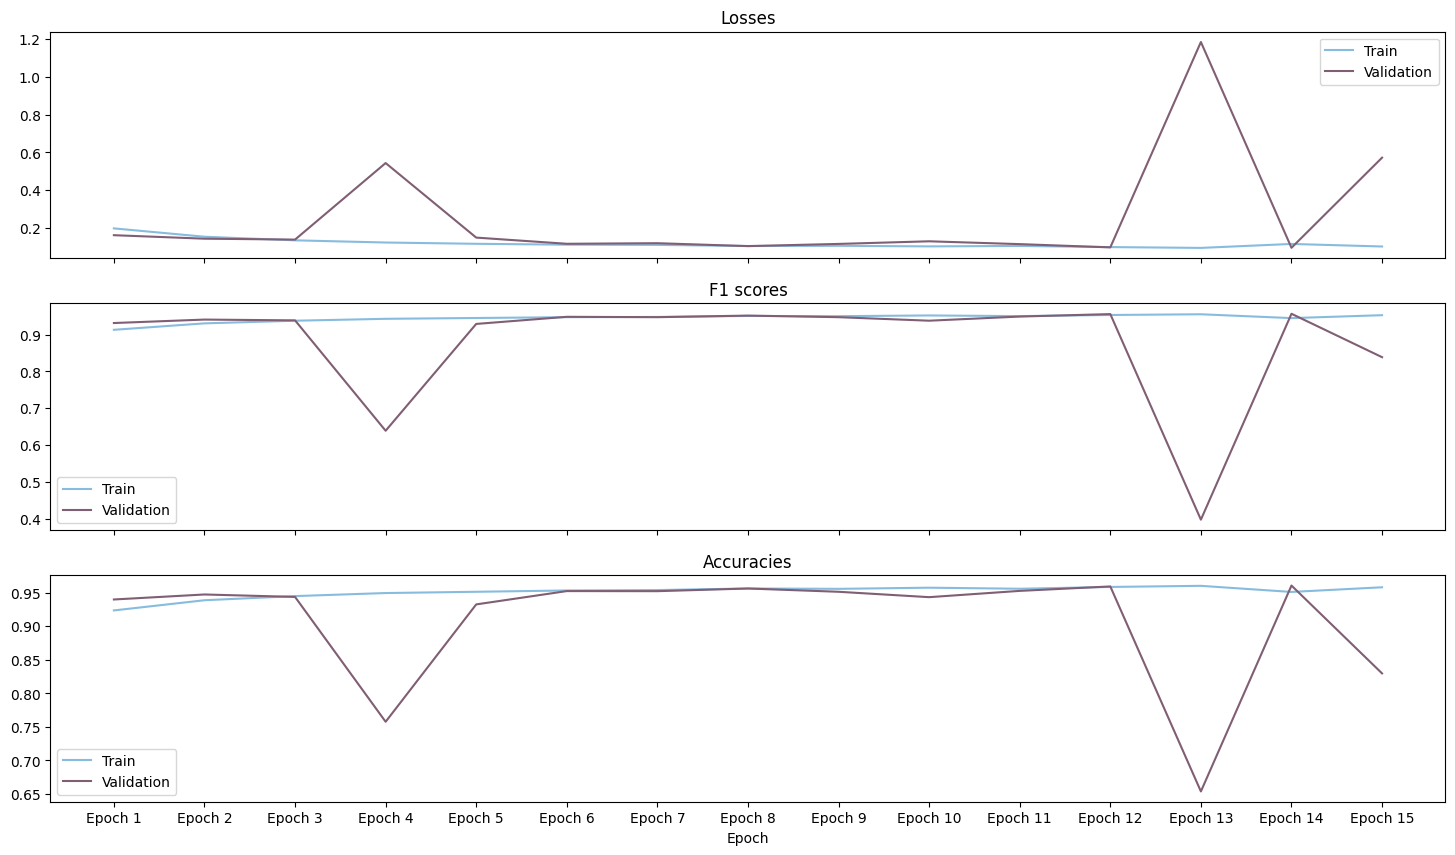

In [12]:
modelname4 = 'augmented_model_both'
lr = 8e-4
model_both = Model(modelname4, lr = lr)
model_both.train(train0_and_1_dataset_augmented,num_epochs= n_epochs)
model_both.plot_history()

In [16]:
train0_and_1_dataset_augmented.deload()
test_records = fill_test_record(
                test_records,
                modelname4,
                model_both,
                'both_dates_augmented',
                [test0_dataset, test1_dataset])

display(test_records)

del train0_and_1_dataset_augmented

100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


,model,trained_on,best_epoch,train1,train0,train0_augmented,train1_augmented,train0&1_augmented,test0,test1,both_dates_augmented
0,no_augmentation_model,train0,11,0.837378,0.965033,NaN,NaN,NaN,0.940868,0.791576,NaN
1,augmented_model0,train0_augmented,12,0.844863,NaN,0.966553,NaN,NaN,0.948449,0.755850,NaN
2,augmented_model1,train1_augmented,13,NaN,0.93453,NaN,0.952662,NaN,0.861882,0.779487,NaN
0,augmented_model_both,both_dates_augmented,14,None,None,None,None,None,0.945247,0.771722,0.956466


- Best model overall : augmented_model0 at epoch 12 on test0
- Surprisingly, no_augmentation model does better on test 1 than any other including augmeented_model1 and augmented_model_both
- training on both date does not show significants improvements and is less performant than having one model for each date.